# Classificação de Imagens Utilizando Redes Neurais Convolucionais

## Bibliotecas

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
import os
import locale
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import resample
from tensorflow.keras.models import Model
from sklearn.metrics import precision_recall_curve,average_precision_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling2D, GlobalAveragePooling2D,Dropout

#
from matplotlib.ticker import FuncFormatter
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

seed_value = 42
tf.random.set_seed(seed_value)

## Carregando o script com funções do tcc
import functions_tcc  ## Importação das funções usadas no script
function_tcc = functions_tcc.func_tcc()

## Caminhos da base de dados

> Como a ideia de aumentarmos a produtividade durante a aplicação do código, iremos definir de inicio os caminhos das pastas com os arquivos em variáveis.

In [31]:
t = "Base de dados original\\chest_xray\\chest_xray\\test\\PNEUMONIA"

In [32]:
range(len(os.listdir(t)))

range(0, 390)

In [33]:
pneumo_cat = [os.listdir(t)[i].split("_")[1] for i in range(len(os.listdir(t)))]
# os.listdir(t)[300].split("_")[1]

In [34]:
pd.value_counts(pneumo_cat)

bacteria    242
virus       148
dtype: int64

*Porém, não iremos destinguir as imagens de Pneumonia nas duas classes listadas acima. Neste trabalho o objetivo é classificar apenas radiografias infantis que possuem ou não Pneumonia, sem distinção de ser causada por vírus ou bactérias.*

> Contagem de dados

In [35]:
train = 'Dados\\chest_xray_desbalanceado\\train'
test  = 'Dados\\chest_xray_desbalanceado\\test'
valid = 'Dados\\chest_xray_desbalanceado\\val'

In [36]:
quant_treino = {
    'Categoria': ['Normal','Pneumonia'],
    'Quant_train': [len(os.listdir(os.path.join(train, 'NORMAL'))),len(os.listdir(os.path.join(train, 'PNEUMONIA')))]
}

quant_teste = {
    'Categoria': ['Normal','Pneumonia'],
    'Quant_test': [len(os.listdir(os.path.join(test, 'NORMAL'))),len(os.listdir(os.path.join(test, 'PNEUMONIA')))]
}

quant_val = {
    'Categoria': ['Normal','Pneumonia'],
    'Quant_val': [len(os.listdir(os.path.join(valid, 'NORMAL'))),len(os.listdir(os.path.join(valid, 'PNEUMONIA')))]
}

quant_treino = pd.DataFrame(quant_treino)
quant_teste = pd.DataFrame(quant_teste)
quant_val = pd.DataFrame(quant_val)

> Visualizando as quantidades

In [37]:
quantidade = pd.merge(quant_treino,quant_teste, on= 'Categoria', how='left')
quantidade = pd.merge(quantidade,quant_val, on= 'Categoria', how='left')
quantidade


,Categoria,Quant_train,Quant_test,Quant_val
0,Normal,1341,234,8
1,Pneumonia,3875,390,8


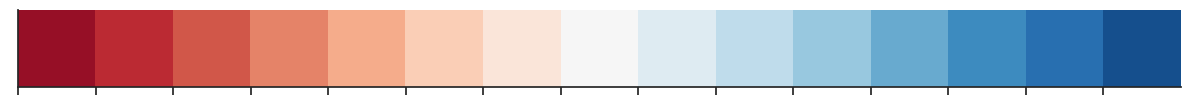

In [38]:
colors = sns.color_palette("RdBu", 15)
sns.palplot(colors)

color_pallete = []
color_pallete.append([colors[14],colors[2]])

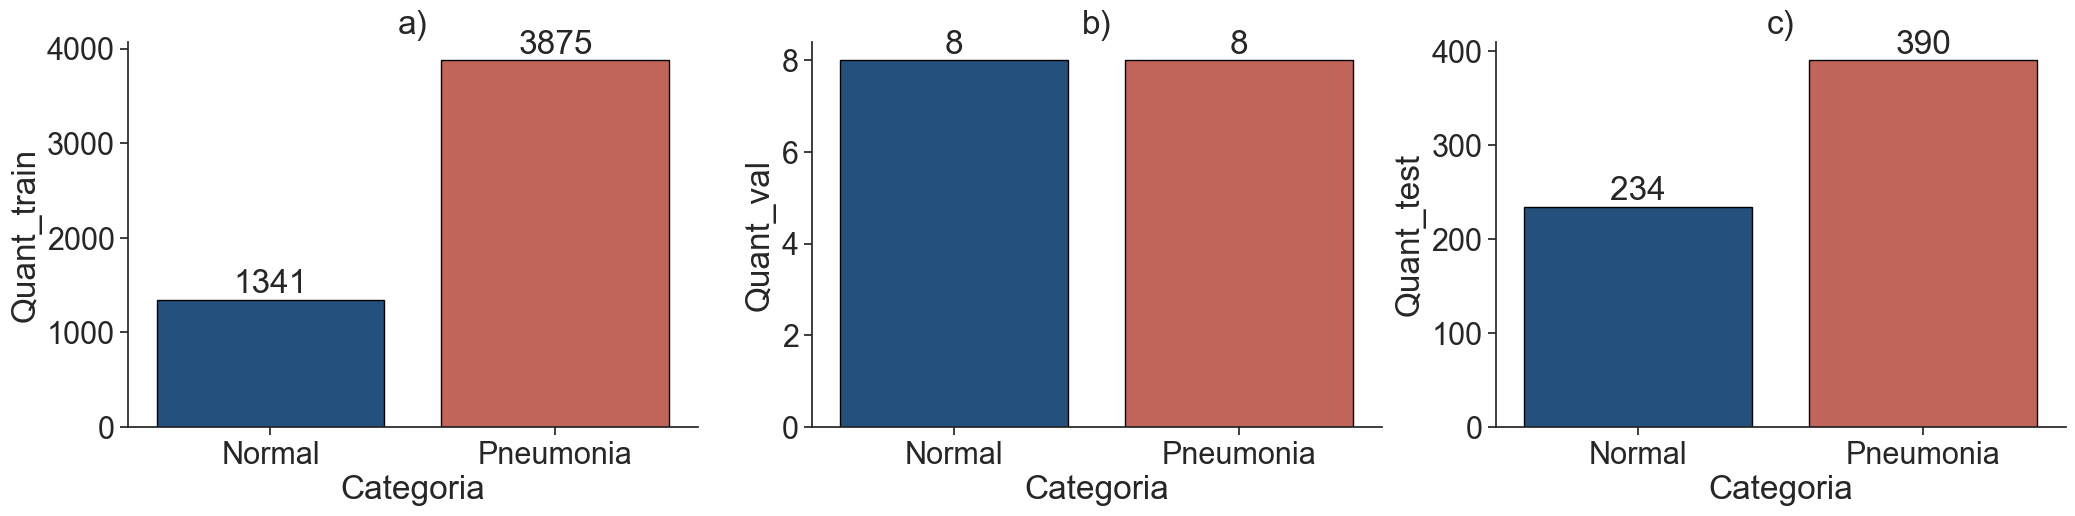

In [42]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette=color_pallete[0], font_scale=2)
#sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(1,3, figsize = (25,5))

# Gráfico base treino
sns.barplot(data = quant_treino, x = quant_treino['Categoria'], y = quant_treino['Quant_train'], ax=ax[0],edgecolor="black", linewidth=1)
ax[0].set_title('a)')
for index, row in quant_treino.iterrows():
    ax[0].annotate(str(row['Quant_train']), (index, row['Quant_train']), ha='center', va='bottom')

# Gráfico base validação
sns.barplot(data = quant_val, x = quant_val['Categoria'], y = quant_val['Quant_val'], ax=ax[1],edgecolor="black", linewidth=1,
            )
ax[1].set_title('b)')
for index, row in quant_val.iterrows():
    ax[1].annotate(str(row['Quant_val']), (index, row['Quant_val']), ha='center', va='bottom')

# Gráfico base teste
sns.barplot(data = quant_teste, x = quant_teste['Categoria'], y = quant_teste['Quant_test'], ax=ax[2],edgecolor="black", linewidth=1)
ax[2].set_title('c)')
for index, row in quant_teste.iterrows():
    ax[2].annotate(str(row['Quant_test']), (index, row['Quant_test']), ha='center', va='bottom')




plt.show()

> Exemplo de imagens na base de dados

In [43]:
img_normal = function_tcc.amostragem('Dados\\chest_xray_desbalanceado\\train\\NORMAL', n = 1)[0]
img_pneumo = function_tcc.amostragem('Dados\\chest_xray_desbalanceado\\train\\PNEUMONIA', n = 1)[0]

img_normal = function_tcc.leitura(classe='Normal', img_path=img_normal)
img_pneumo = function_tcc.leitura(classe='Pneumonia', img_path=img_pneumo)

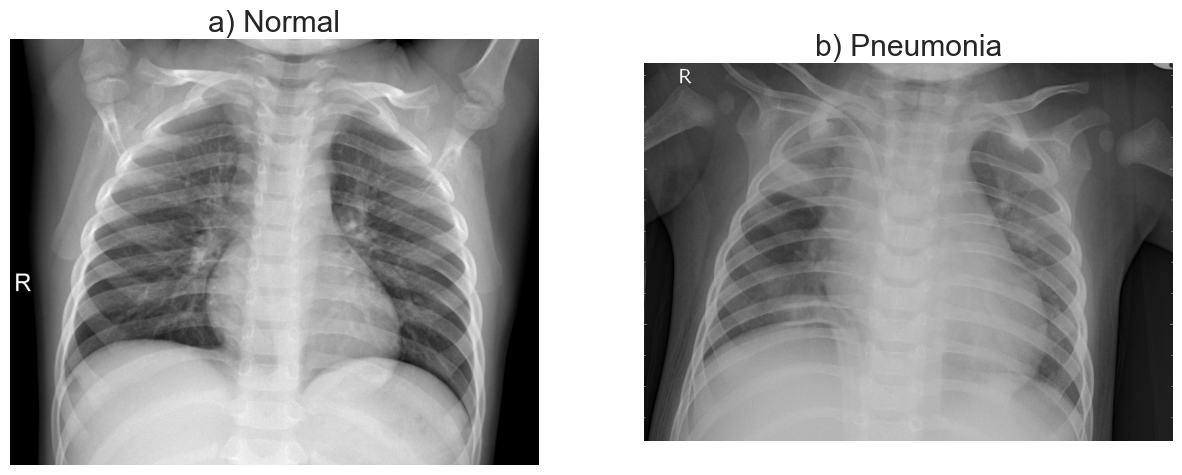

In [44]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, font_scale=1.8)

fig, ax = plt.subplots(1,2, figsize = (15,8))

#
ax[0].imshow(img_normal)
ax[0].set_title('a) Normal')
ax[0].axis("off")

#
ax[1].imshow(img_pneumo)
ax[1].set_title('b) Pneumonia')
ax[1].axis("off")

plt.show()

## Criando as bases de treino e teste


In [45]:
gerador_treinamento = ImageDataGenerator(
    rescale = 1./255, #normalizar os pixels da imagem
    rotation_range = 7, # será realizado algumas rotações
    horizontal_flip = True, # será realizado rotações na horizontal 
    zoom_range = 0.2
)

gerador_teste = ImageDataGenerator(
    rescale = 1./255
)

gerador_val = ImageDataGenerator(
    rescale = 1./255
)

**Criando datasets específicos para cada CNN utilizada**

> InceptionResNetV2

In [46]:
ds_train_Incep = gerador_treinamento.flow_from_directory(train,
                                                              target_size = (299,299), # redimensionando as imagens
                                                              batch_size = 50,
                                                              class_mode = 'categorical',
                                                              shuffle = True
                                                              )

ds_test_Incep = gerador_teste.flow_from_directory(test,
                                                target_size = (299,299), # redimensionando as imagens
                                                batch_size = 1,
                                                class_mode = 'categorical',
                                                shuffle = False
                                                )

ds_val_Incep= gerador_val.flow_from_directory(valid,
                                                target_size = (299,299), # redimensionando as imagens
                                                batch_size = 1,
                                                class_mode = 'categorical',
                                                shuffle = False
                                                )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


> VGG16


In [47]:
ds_train_vgg = gerador_treinamento.flow_from_directory(train,
                                                              target_size = (224,224), # redimensionando as imagens
                                                              batch_size = 50,
                                                              class_mode = 'categorical',
                                                              shuffle = True
                                                              )

ds_test_vgg= gerador_teste.flow_from_directory(test,
                                                target_size = (224,224), # redimensionando as imagens
                                                batch_size = 1,
                                                class_mode = 'categorical',
                                                shuffle = False
                                               )

ds_val_vgg= gerador_val.flow_from_directory(valid,
                                                target_size = (224,224), # redimensionando as imagens
                                                batch_size = 1,
                                                class_mode = 'categorical',
                                                shuffle = False
                                                )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Carregando as arquiteturas de CNN

In [48]:
modelo_Incep = tf.keras.applications.InceptionResNetV2(
    weights='imagenet', # definir os pesos
    include_top=False, # False -> não iremos carregar as camadas densas da rede neural
    input_tensor= Input(shape = (299,299,3)) # dimensão das imagens e numero de canais de cor
)

modelo_VGG = tf.keras.applications.VGG16(
    weights='imagenet', # definir os pesos
    include_top=False, # False -> não iremos carregar as camadas densas da rede neural
    input_tensor= Input(shape = (224,224,3)) # dimensão das imagens e numero de canais de cor
)



In [49]:
print('Número de pesos ajustáveis sem utilizar a rede convolucional:', len(modelo_VGG.trainable_weights))
modelo_Incep.trainable = False
print('Número de pesos ajustáveis utilizando a rede convolucional::', len(modelo_VGG.trainable_weights))

Número de pesos ajustáveis sem utilizar a rede convolucional: 26
Número de pesos ajustáveis utilizando a rede convolucional:: 26


In [51]:
modelo_Incep.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

In [50]:
modelo_VGG.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**Como o objetivo da utilização do transferlearning é utilizar os pesos já treinados de uma CNN, precisaremos travar as camadas da rede convoluncional das arquiteturas para que neste primeiro mmomento não seja efetuado um retreinamento nos pesos**

In [52]:
# Inception
for layer in modelo_Incep.layers:
    layer.trainable = False 

# VGG16
for layer in modelo_VGG.layers:
    layer.trainable = False 

In [53]:
print('Quantidades de neuronios que iremos utilizar:')
print("Inception: {}".format((modelo_Incep.output.shape[3] + 2)/2))
print("VGG16: {}".format((modelo_VGG.output.shape[3] + 2)/2))

Quantidades de neuronios que iremos utilizar:
Inception: 769.0
VGG16: 257.0


*Para construirmos uma rede neural densa, precisaremos da quantidade de neurônios de saída de cada modelo, logo:*

In [54]:
print("Inception -> Saída: {} -> Entrada na rede neural densa: {} -> Saída: 2".format(modelo_Incep.output.shape[3],(modelo_Incep.output.shape[3] + 2)/2))
print("VGG16 -> Saída: {} -> Entrada na rede neural densa: {} -> Saída: 2".format(modelo_VGG.output.shape[3],(modelo_VGG.output.shape[3] + 2)/2))

Inception -> Saída: 1536 -> Entrada na rede neural densa: 769.0 -> Saída: 2
VGG16 -> Saída: 512 -> Entrada na rede neural densa: 257.0 -> Saída: 2


#### Inception

In [55]:
## Construção da rede neural densa
model_dense = modelo_Incep.output

model_dense= GlobalAveragePooling2D()(model_dense)
model_dense = Dense(units = 769, activation = 'relu')(model_dense)
model_dense = Dropout(rate=0.2)(model_dense)
model_dense = Dense(units = 769, activation = 'relu')(model_dense)
model_dense = Dropout(rate=0.2)(model_dense)

# Camada de saida
model_dense= Dense(units = 2, activation = 'softmax')(model_dense)

In [56]:
## unindo com a base concolucional
RN_Incep = Model(inputs = modelo_Incep.input,
                       outputs = model_dense)

In [57]:
RN_Incep.compile(optimizer='Adam', loss='categorical_crossentropy',
                       metrics = ['accuracy'])

In [58]:
RN_Incep.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

> Realizando o Treinamento do modelo Inception-ResNet-V2

In [ ]:
historico_Incep = RN_Incep.fit(ds_train_Incep,
                                  validation_data = ds_val_Incep, epochs=10)

Epoch 1/10
105/105 [==============================] - 199s 2s/step - loss: 0.3289 - accuracy: 0.8689 - val_loss: 0.4109 - val_accuracy: 0.8750
Epoch 2/10
105/105 [==============================] - 124s 1s/step - loss: 0.1922 - accuracy: 0.9283 - val_loss: 0.4823 - val_accuracy: 0.8125
Epoch 3/10
105/105 [==============================] - 124s 1s/step - loss: 0.1591 - accuracy: 0.9375 - val_loss: 0.5491 - val_accuracy: 0.8125
Epoch 4/10
105/105 [==============================] - 124s 1s/step - loss: 0.1537 - accuracy: 0.9392 - val_loss: 0.2676 - val_accuracy: 0.8750
Epoch 5/10
105/105 [==============================] - 123s 1s/step - loss: 0.1502 - accuracy: 0.9425 - val_loss: 0.2359 - val_accuracy: 0.8750
Epoch 6/10
105/105 [==============================] - 123s 1s/step - loss: 0.1278 - accuracy: 0.9505 - val_loss: 0.1734 - val_accuracy: 0.8750
Epoch 7/10
105/105 [==============================] - 128s 1s/step - loss: 0.1383 - accuracy: 0.9442 - val_loss: 0.3710 - val_accuracy: 0.8125

#### VGG16

In [ ]:
### ligação dos neuronios

model_dense = modelo_VGG.output

model_dense= GlobalAveragePooling2D()(model_dense)
model_dense = Dense(units = 257, activation = 'relu')(model_dense)
model_dense = Dropout(rate=0.2)(model_dense)
model_dense = Dense(units = 257, activation = 'relu')(model_dense)
model_dense = Dropout(rate=0.2)(model_dense)

# Camada de saida
model_dense= Dense(units = 2, activation = 'softmax')(model_dense)

In [ ]:
RN_VGG = Model(inputs = modelo_VGG.input,
                       outputs = model_dense)

In [ ]:
RN_VGG.compile(optimizer='Adam', loss='categorical_crossentropy',
                       metrics = ['accuracy'])

In [ ]:
RN_VGG.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

> Realizando o treinamento do modelo VGG-16

In [ ]:
historico_VGG = RN_VGG.fit(ds_train_vgg,
                                  validation_data = ds_val_vgg, epochs=10)

Epoch 1/10
105/105 [==============================] - 99s 859ms/step - loss: 0.3556 - accuracy: 0.8319 - val_loss: 0.8341 - val_accuracy: 0.7500
Epoch 2/10
105/105 [==============================] - 86s 822ms/step - loss: 0.2084 - accuracy: 0.9197 - val_loss: 0.8439 - val_accuracy: 0.7500
Epoch 3/10
105/105 [==============================] - 86s 820ms/step - loss: 0.1753 - accuracy: 0.9304 - val_loss: 0.8118 - val_accuracy: 0.7500
Epoch 4/10
105/105 [==============================] - 86s 820ms/step - loss: 0.1793 - accuracy: 0.9266 - val_loss: 0.8456 - val_accuracy: 0.7500
Epoch 5/10
105/105 [==============================] - 86s 821ms/step - loss: 0.1597 - accuracy: 0.9406 - val_loss: 0.9354 - val_accuracy: 0.7500
Epoch 6/10
105/105 [==============================] - 86s 820ms/step - loss: 0.1504 - accuracy: 0.9425 - val_loss: 0.6968 - val_accuracy: 0.7500
Epoch 7/10
105/105 [==============================] - 86s 819ms/step - loss: 0.1669 - accuracy: 0.9316 - val_loss: 0.4264 - val_ac

## Salvando o modelo

> Inception

In [52]:
## Salvando os pesos treinados e o modelo
function_tcc.save_model(model = RN_Incep, path_save = 'Modelos\\Base Desbalanceada',
                        type = 'model', nome = 'Inception_model')

function_tcc.save_model(model = RN_Incep, path_save = 'Modelos\\Base Desbalanceada',
                        type = 'weight', nome = 'Inception_weights')

NameError: name 'RN_Incep' is not defined

*O erro da célula acima não interfere nos processos a seguir, o modelo já tinha sido salvo corretamente pelo mesmo código e para evitar resultados diferentes no treinamento, foi deixado da forma inicial que foi estabelecido.*

In [ ]:
# Salvando o histórico
function_tcc.save_model(model = historico_Incep,path_save = 'Modelos\\Base Desbalanceada',
                        type = 'historic', nome = 'historico_incep' )

> VGG16

In [ ]:
## Salvando os pesos treinados e o modelo
function_tcc.save_model(model = RN_VGG, path_save = 'Modelos\\Base Desbalanceada',
                        type = 'model', nome = 'VGG_model')

function_tcc.save_model(model = RN_VGG, path_save = 'Modelos\\Base Desbalanceada',
                        type = 'weight', nome = 'VGG_weights')

In [ ]:
# Salvando o histórico
function_tcc.save_model(model = historico_VGG,path_save = 'Modelos\\Base Desbalanceada',
                        type = 'historic', nome = 'historico_vgg' )

## Carregando os Modelos e pesos já salvos

> Inception

In [59]:
## Carregando o histórico de treinamen
historico_Incep = function_tcc.load_model(path_load = 'Modelos\\Base Desbalanceada\\historico_incep.pickle',
                                          type = 'historic')

In [60]:
## Carregando o modelo e os pesos
RN_inception_loaded = function_tcc.load_model(path_load = 'Modelos\\Base Desbalanceada\\Inception_model.json',
                                              weight_ph = 'Modelos\\Base Desbalanceada\\Inception_weights.hdf5',
                                              type = 'model')

In [24]:
RN_inception_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

> VGG16

In [61]:
## Carregando o histórico de treinamen
historico_VGG = function_tcc.load_model(path_load = 'Modelos\\Base Desbalanceada\\historico_vgg.pickle',
                                          type = 'historic')

In [62]:
## Carregando o modelo e os pesos
RN_vgg_loaded = function_tcc.load_model(path_load = 'Modelos\\Base Desbalanceada\\VGG_model.json',
                                              weight_ph = 'Modelos\\Base Desbalanceada\\VGG_weights.hdf5',
                                              type = 'model')

In [27]:
RN_vgg_loaded.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Avaliação dos modelos

In [63]:
historico_Incep.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [58]:
np.arange(1,11)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [64]:
### acurácia
acc_incp = historico_Incep['accuracy']
acc_vgg = historico_VGG['accuracy']

val_acc_incep = historico_Incep['val_accuracy']
val_acc_vgg = historico_VGG['val_accuracy']

### Erro
loss_incp = historico_Incep['loss']
loss_vgg = historico_VGG['loss']

loss_val_incp = historico_Incep['val_loss']
loss_val_vgg = historico_VGG['val_loss']

> Curva de aprendizagem para o modelo Inception-ResNet-V2

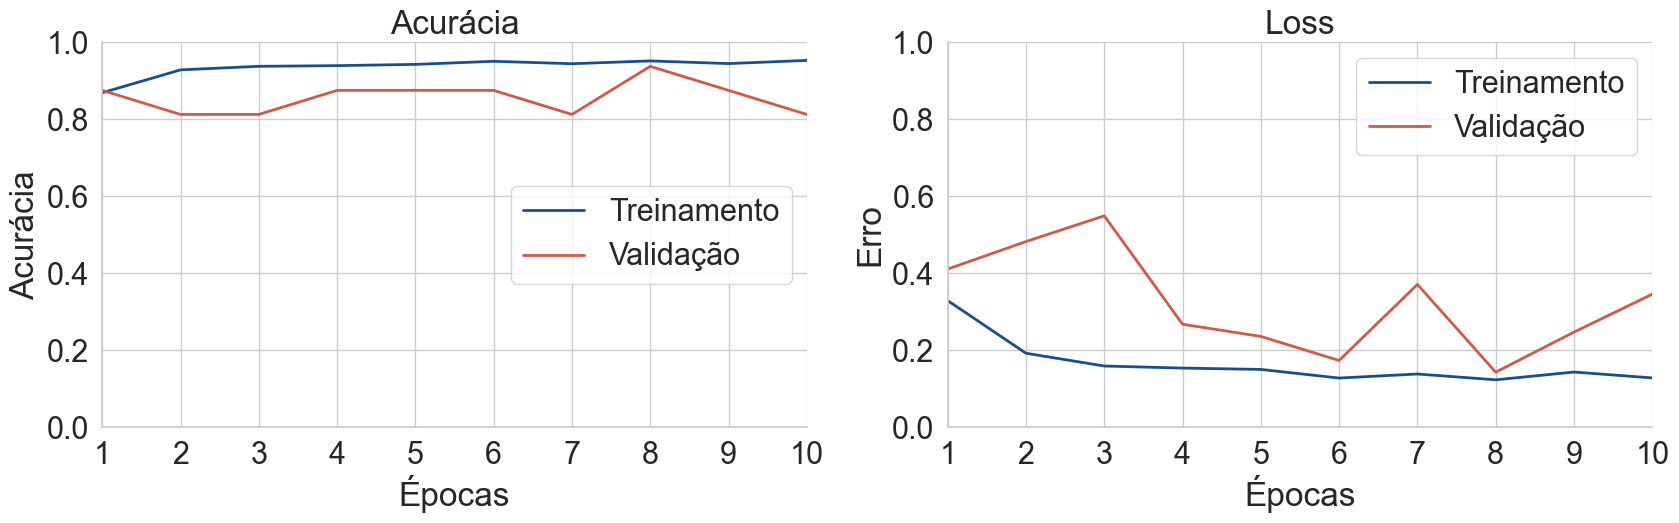

In [66]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params, 
              palette=color_pallete[0], font_scale=2)
#sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(1,2, figsize = (20,5))

# incep
sns.lineplot(acc_incp, label='Treinamento',ax = ax[0], linewidth = 2)
sns.lineplot(val_acc_incep, label='Validação',ax = ax[0], linewidth = 2)
ax[0].set_ylim([0,1])
ax[0].set_xlim([0,9])
ax[0].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[0].legend(loc='center right') 
ax[0].set_title("Acurácia")
ax[0].set_xlabel("Épocas")
ax[0].set_ylabel("Acurácia")

# incep
sns.lineplot(loss_incp, label='Treinamento',ax = ax[1], linewidth = 2)
sns.lineplot(loss_val_incp, label='Validação',ax = ax[1], linewidth = 2)

ax[1].set_ylim([0,1])
ax[1].set_xlim([0,9])
ax[1].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[1].legend(loc='upper right') 
ax[1].set_title("Loss")
ax[1].set_xlabel("Épocas")
ax[1].set_ylabel("Erro")

plt.show()

> Curva de aprendizagem para o modelo VGG-16

Text(0, 0.5, 'Erro')

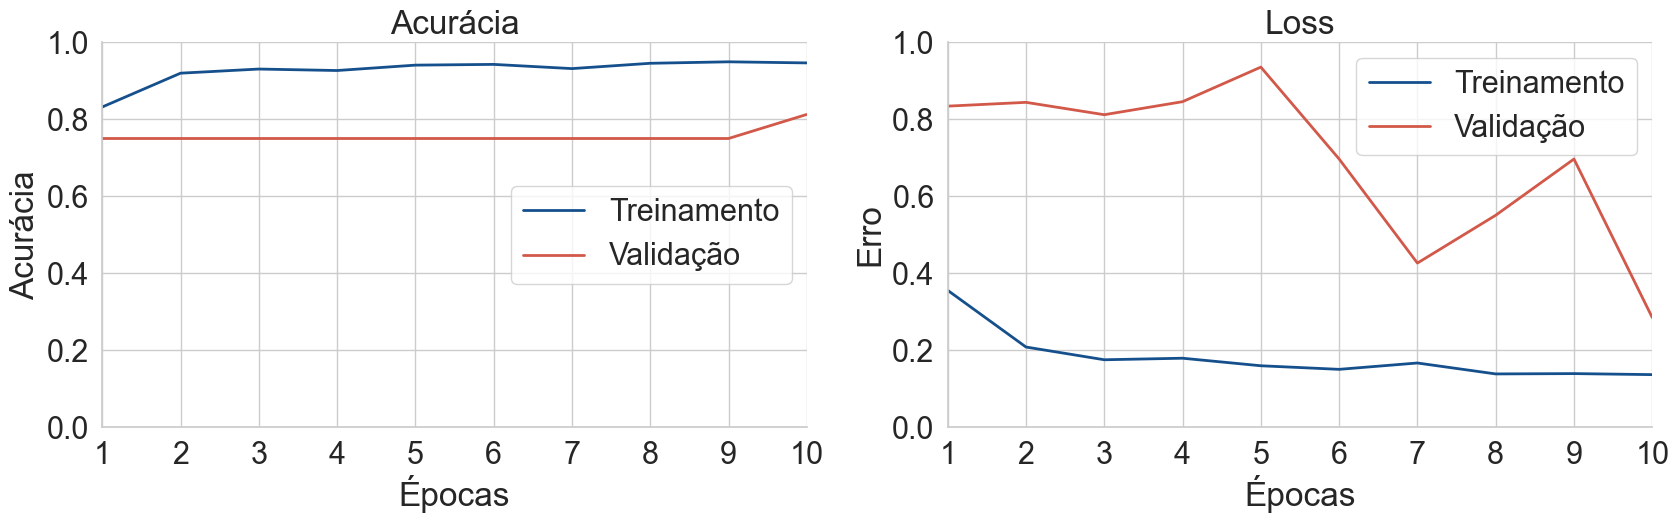

In [67]:

fig, ax = plt.subplots(1,2, figsize = (20,5))

# vgg
sns.lineplot(acc_vgg, label='Treinamento',ax = ax[0], linewidth = 2)
sns.lineplot(val_acc_vgg, label='Validação',ax = ax[0], linewidth = 2)
ax[0].set_ylim([0,1])
ax[0].set_xlim([0,9])
ax[0].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[0].legend(loc='center right') 
ax[0].set_title("Acurácia")
ax[0].set_xlabel("Épocas")
ax[0].set_ylabel("Acurácia")


# vgg
sns.lineplot(loss_vgg, label='Treinamento',ax = ax[1], linewidth = 2)
sns.lineplot(loss_val_vgg, label='Validação',ax = ax[1], linewidth = 2)

ax[1].set_ylim([0,1])
ax[1].set_xlim([0,9])
ax[1].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[1].legend(loc='upper right') 
ax[1].set_title("Loss")
ax[1].set_xlabel("Épocas")
ax[1].set_ylabel("Erro")

> Comparaçao da curva de aprendizagem entre os dois modelos

Text(0, 0.5, 'Erro')

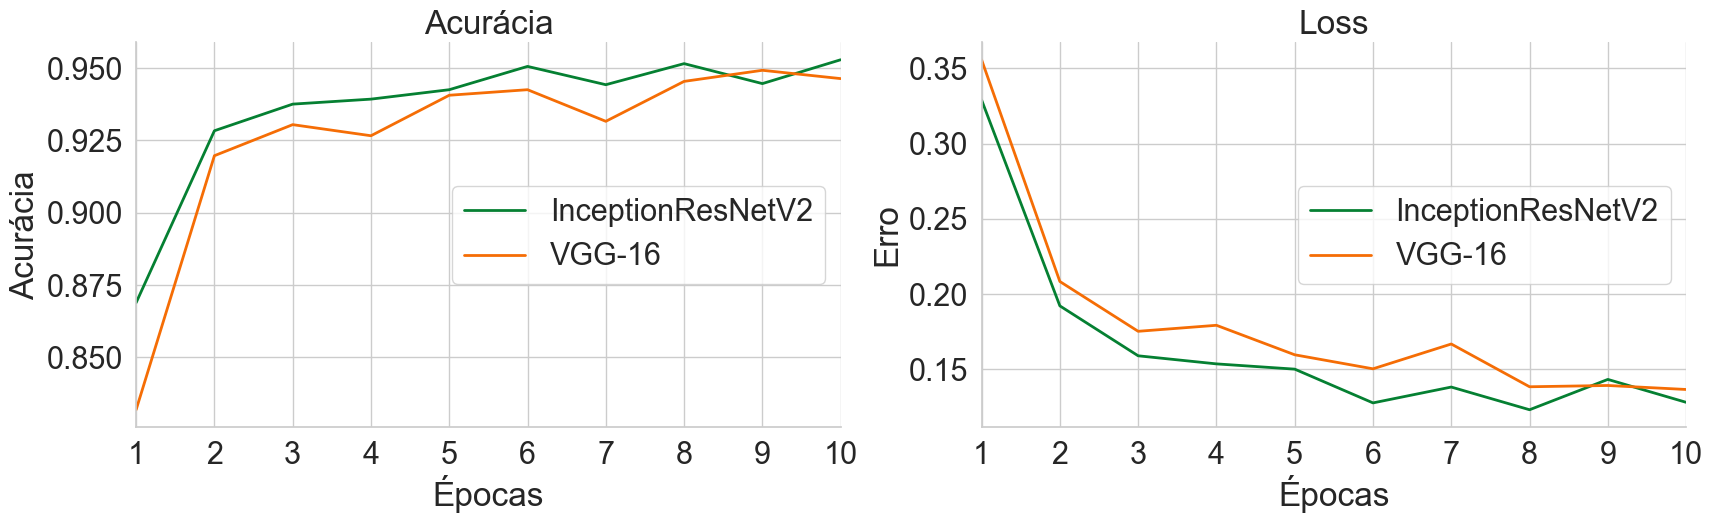

In [68]:
loss_incp = historico_Incep['loss']
loss_vgg = historico_VGG['loss']

sns.set_theme(style="whitegrid", rc=custom_params, 
              palette=["#058032","#f56d05"], font_scale=2)

fig, ax = plt.subplots(1,2, figsize = (20,5))

# incep
sns.lineplot(acc_incp, label='InceptionResNetV2',ax = ax[0], linewidth = 2)
sns.lineplot(acc_vgg, label='VGG-16',ax = ax[0], linewidth = 2)
# ax[0].set_ylim([0,1])
ax[0].set_xlim([0,9])
ax[0].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[0].legend(loc='center right') 
ax[0].set_title("Acurácia")
ax[0].set_xlabel("Épocas")
ax[0].set_ylabel("Acurácia")

# vgg
sns.lineplot(loss_incp, label='InceptionResNetV2',ax = ax[1], linewidth = 2)
sns.lineplot(loss_vgg, label='VGG-16',ax = ax[1], linewidth = 2)

# ax[1].set_ylim([0,1])
ax[1].set_xlim([0,9])
ax[1].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[1].legend(loc='center right') 
ax[1].set_title("Loss")
ax[1].set_xlabel("Épocas")
ax[1].set_ylabel("Erro")

## Classificação

In [69]:
prev_incep_1 = RN_inception_loaded.predict(ds_test_Incep)
prev_incep = np.argmax(prev_incep_1, axis = 1)

prev_vgg_1 = RN_vgg_loaded.predict(ds_test_vgg)
prev_vgg = np.argmax(prev_vgg_1, axis = 1)

624/624 [==============================] - 9s 12ms/step


> Definindo as cores a serem utilizadas

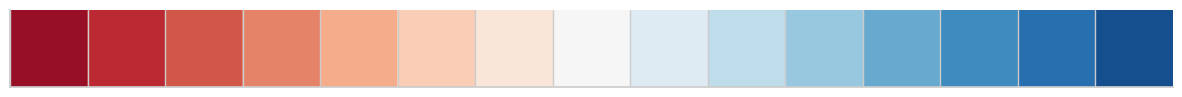

In [70]:
colors = sns.color_palette("RdBu", 15)
sns.palplot(colors)

In [71]:
color_pallete2 = []
color_pallete2.append([colors[6],colors[14],colors[2]])
color_pallete2[0]

[(0.9829296424452134, 0.9018838908112264, 0.8542099192618224),
 (0.08419838523644753, 0.31280276816609, 0.5534025374855824),
 (0.8226066897347174, 0.34325259515570933, 0.28627450980392155)]

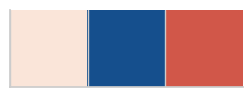

In [72]:
sns.palplot(color_pallete2[0])


> Matriz de Confusão

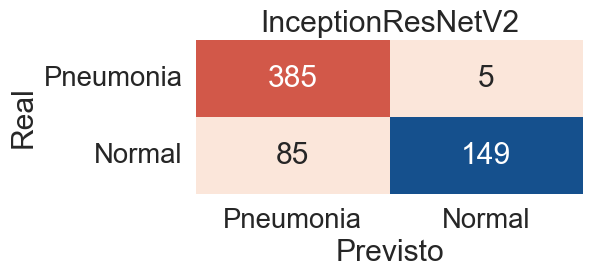

In [75]:
label = ['Pneumonia', "Normal"]
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.8)
fig, ax = plt.subplots(figsize = (5,2))

cm_1 = confusion_matrix(ds_test_Incep.classes, prev_incep, labels=[1,0])
sns.heatmap(cm_1, annot=True,fmt='d', xticklabels=label, 
            yticklabels=label,cmap= color_pallete2[0], cbar=False)
ax.set_title('InceptionResNetV2')
ax.set_xlabel("Previsto")
ax.set_ylabel("Real")

plt.show()

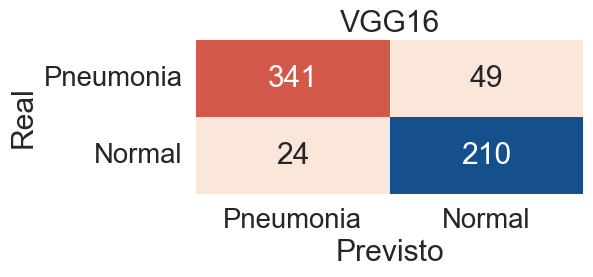

In [76]:
label = ['Pneumonia', "Normal"]
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.8)
fig, ax = plt.subplots( figsize = (5,2))

cm_2 = confusion_matrix(ds_test_vgg.classes, prev_vgg, labels=[1,0])
sns.heatmap(cm_2, annot=True,fmt='d',  xticklabels=label, 
            yticklabels=label,cmap=color_pallete2[0], cbar=False)
ax.set_title('VGG16')
ax.set_xlabel("Previsto")
ax.set_ylabel("Real")

plt.show()

> Visualização das métricas de avaliação pelo Classification Report

In [78]:
print('-------------------------------------------------------')
print('>>>>>>>>>>>>>>> Classification Report <<<<<<<<<<<<<<<<<')
print('-------------------------------------------------------')
print('----------------> InceptionResNetV2 <------------------')
c1 = classification_report(ds_test_Incep.classes, prev_incep,target_names=label,labels=[1,0])
print(c1)
print('-------------------------------------------------------')
# print('\n')
print('----------------------> VGG16 <------------------------')
c2 = classification_report(ds_test_vgg.classes, prev_vgg,
                           target_names=label,labels=[1,0])
print(c2)
print('-------------------------------------------------------')

-------------------------------------------------------
>>>>>>>>>>>>>>> Classification Report <<<<<<<<<<<<<<<<<
-------------------------------------------------------
----------------> InceptionResNetV2 <------------------
              precision    recall  f1-score   support

   Pneumonia       0.82      0.99      0.90       390
      Normal       0.97      0.64      0.77       234

    accuracy                           0.86       624
   macro avg       0.89      0.81      0.83       624
weighted avg       0.87      0.86      0.85       624

-------------------------------------------------------
----------------------> VGG16 <------------------------
              precision    recall  f1-score   support

   Pneumonia       0.93      0.87      0.90       390
      Normal       0.81      0.90      0.85       234

    accuracy                           0.88       624
   macro avg       0.87      0.89      0.88       624
weighted avg       0.89      0.88      0.88       624

----------

#### Curva ROC e a Curva de Precision-Recall


> **fpr**: *False positive rate* \
> **tpr**: *True positive rate*

In [79]:
fpr_inc, tpr_inc, _ = roc_curve(ds_test_Incep.classes, prev_incep)
fpr_vgg, tpr_vgg, _ = roc_curve(ds_test_vgg.classes, prev_vgg)

roc_auc_inc = auc(fpr_inc, tpr_inc)
roc_auc_vgg = auc(fpr_vgg, tpr_vgg)

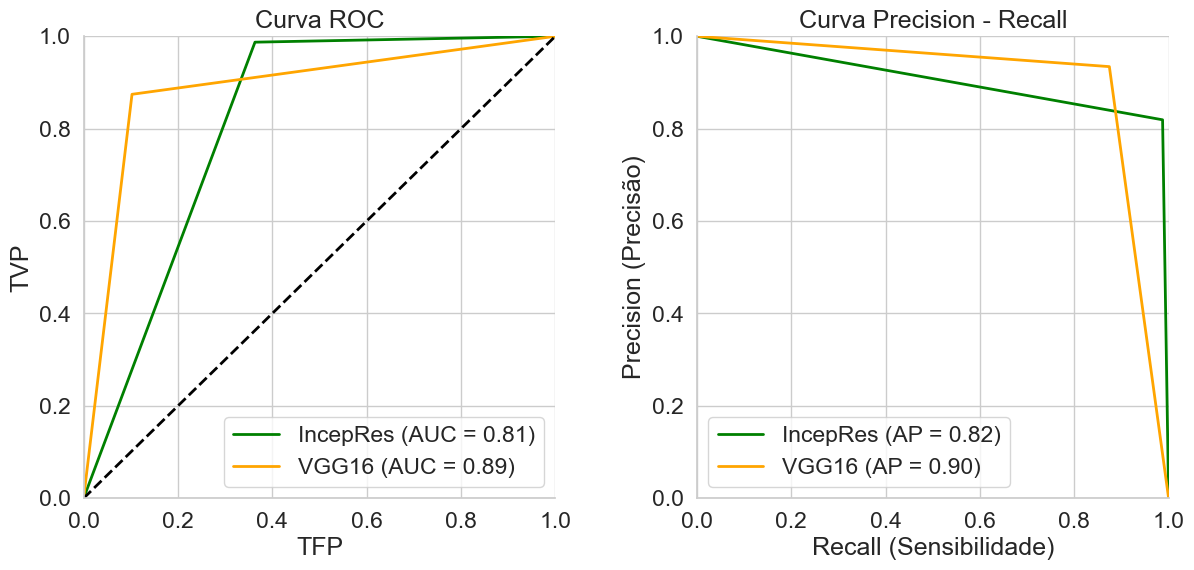

In [83]:
from sklearn.metrics import precision_recall_curve,average_precision_score

precision, recall, thresholds = precision_recall_curve(ds_test_Incep.classes, prev_incep)
precision2, recall2, thresholds2 = precision_recall_curve(ds_test_vgg.classes, prev_vgg)

precision[0] = 0
precision2[0] = 0

ap_incep = average_precision_score(ds_test_Incep.classes, prev_incep)
ap_vgg = average_precision_score(ds_test_vgg.classes, prev_vgg)

sns.set_theme(style="whitegrid", rc=custom_params, 
              palette=["Green","Orange"], font_scale=1.5)

fig, ax = plt.subplots(1,2, figsize = (14,6))
plt.subplots_adjust(wspace=0.3)

ax[0].plot(fpr_inc, tpr_inc, lw=2, label='IncepRes (AUC = %0.2f)' % roc_auc_inc)
ax[0].plot(fpr_vgg, tpr_vgg, lw=2, label='VGG16 (AUC = %0.2f)' % roc_auc_vgg)
ax[0].plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
ax[0].set_xlabel('TFP')
ax[0].set_ylabel('TVP')
ax[0].set_title('Curva ROC')
ax[0].legend(loc="lower right")
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1])

# Plota a curva de precisão e recall
ax[1].plot(recall, precision, lw =2 ,label = 'IncepRes (AP = %.2f)' % ap_incep)
ax[1].plot(recall2, precision2,lw =2,label = 'VGG16 (AP = %.2f)' % ap_vgg)
ax[1].set_xlabel('Recall (Sensibilidade)')
ax[1].set_ylabel('Precision (Precisão)')
ax[1].set_title('Curva Precision - Recall')
# ax[1].grid(True)
ax[1].legend(loc="lower left")
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1])


plt.show()

## Fine tunning


**Neste caso será aplicado o *Shallow fin-tuned* um tipo de ajuste fino (fine tunning) em que as camadas finais da parte convolucional serão retreinadas com os dados da base atual.**

*Para a aplicação deste método foi estabelecido que apenas 25% das últimas camadas da parte convolucional, de cada um dos modelos, foram retreinados.**

In [85]:
len(modelo_Incep.layers), len(modelo_VGG.layers)

(780, 19)

In [86]:
modelo_VGG.layers

> Redefinindo todas as camadas do modelo para serem treinaveis

In [88]:
# Inception
for layer in modelo_Incep.layers:
    layer.trainable = True 

# VGG16
for layer in modelo_VGG.layers:
    layer.trainable = True 

> Definindo quais camadas serão treinadas para o modelo da Inception-ResNet-V2

In [89]:
780 - 780*0.25


585.0

In [90]:
fine_tuning_at = 585

In [91]:
for layer in modelo_Incep.layers[:fine_tuning_at]:
    layer.trainable = False

In [92]:
for layer in  modelo_Incep.layers:
    print(layer, layer.trainable )

<keras.engine.input_layer.InputLayer object at 0x000001BF6A5DA050> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001BF6EE64250> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001BF6EE66EC0> False
<keras.layers.core.activation.Activation object at 0x000001BF6EE64F10> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001BF6ED6E530> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001BF6ED6C670> False
<keras.layers.core.activation.Activation object at 0x000001BF6ED6ED10> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001BF6ED6E0E0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001BF6ED6D2D0> False
<keras.layers.core.activation.Activation object at 0x000001BF6ED6CA90> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001BF6ED854B0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001BF6ED865

> Definindo quais camadas serão treinadas para o modelo da VGG-16

In [93]:
### treinaremos 25% da vgg
19 -19*0.25

14.25

In [94]:
fine_tuning_at = 14

In [95]:
for layer  in modelo_VGG.layers[:fine_tuning_at]:
    layer.trainable = False

In [96]:
for layer in  modelo_VGG.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001BF6A5D8940> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001BF6A5DB820> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001BF169158D0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001BF169166B0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001BF168D55A0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001BF16914EE0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001BF16960370> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001BF16621C30> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001BF16962B60> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001BF16963D90> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001BF190A01F0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001BF169607F0> False
<keras.layers.convolutional.conv2d.Conv2D object

### Realizando o Treinamento

> Inception-ResNet-V2

In [ ]:
RN_Incep_FT = Model(inputs = modelo_Incep.input,
                       outputs = model_dense)

In [ ]:
## Compilando a rede neural
RN_Incep_FT.compile(optimizer='Adam', loss='categorical_crossentropy',
                       metrics = ['accuracy'])

historico_Incep = RN_Incep_FT.fit(ds_train_Incep,
                                  validation_data = ds_val_Incep, epochs=10)

Epoch 1/10
105/105 [==============================] - 194s 2s/step - loss: 0.1704 - accuracy: 0.9410 - val_loss: 3.4045 - val_accuracy: 0.5625
Epoch 2/10
105/105 [==============================] - 125s 1s/step - loss: 0.1026 - accuracy: 0.9628 - val_loss: 0.7311 - val_accuracy: 0.8125
Epoch 3/10
105/105 [==============================] - 128s 1s/step - loss: 0.0789 - accuracy: 0.9757 - val_loss: 0.5129 - val_accuracy: 0.8125
Epoch 4/10
105/105 [==============================] - 130s 1s/step - loss: 0.0597 - accuracy: 0.9806 - val_loss: 0.0738 - val_accuracy: 1.0000
Epoch 5/10
105/105 [==============================] - 125s 1s/step - loss: 0.0465 - accuracy: 0.9858 - val_loss: 0.4565 - val_accuracy: 0.7500
Epoch 6/10
105/105 [==============================] - 124s 1s/step - loss: 0.0475 - accuracy: 0.9839 - val_loss: 0.4946 - val_accuracy: 0.8750
Epoch 7/10
105/105 [==============================] - 125s 1s/step - loss: 0.0526 - accuracy: 0.9816 - val_loss: 0.0164 - val_accuracy: 1.0000

> VGG-16

In [ ]:
RN_VGG_FT.compile(optimizer='Adam', loss='categorical_crossentropy',
                       metrics = ['accuracy'])

historico_VGG = RN_VGG_FT.fit(ds_train_vgg,
                                  validation_data = ds_val_vgg, epochs=10)

Epoch 1/10
105/105 [==============================] - 100s 868ms/step - loss: 0.3700 - accuracy: 0.8510 - val_loss: 1.1033 - val_accuracy: 0.6875
Epoch 2/10
105/105 [==============================] - 87s 828ms/step - loss: 0.1468 - accuracy: 0.9454 - val_loss: 0.3663 - val_accuracy: 0.7500
Epoch 3/10
105/105 [==============================] - 87s 826ms/step - loss: 0.1023 - accuracy: 0.9645 - val_loss: 0.7131 - val_accuracy: 0.6875
Epoch 4/10
105/105 [==============================] - 90s 860ms/step - loss: 0.0901 - accuracy: 0.9680 - val_loss: 0.6826 - val_accuracy: 0.6875
Epoch 5/10
105/105 [==============================] - 91s 866ms/step - loss: 0.0807 - accuracy: 0.9745 - val_loss: 0.1543 - val_accuracy: 0.9375
Epoch 6/10
105/105 [==============================] - 88s 834ms/step - loss: 0.0721 - accuracy: 0.9739 - val_loss: 0.0890 - val_accuracy: 1.0000
Epoch 7/10
105/105 [==============================] - 88s 834ms/step - loss: 0.0681 - accuracy: 0.9749 - val_loss: 0.4511 - val_a

### Salvando os modelos

> Inception

In [ ]:
## Salvando os pesos treinados e o modelo
function_tcc.save_model(model = RN_Incep_FT, path_save = 'Modelos\\Base Desbalanceada',
                        type = 'model', nome = 'Inception_model_FT')

function_tcc.save_model(model = RN_Incep_FT, path_save = 'Modelos\\Base Desbalanceada',
                        type = 'weight', nome = 'Inception_weights_FT')

## Salvando o histórico
function_tcc.save_model(model = historico_Incep,path_save = 'Modelos\\Base Desbalanceada',
                        type = 'historic', nome = 'historico_incep_FT' )

> VGG

In [ ]:
## Salvando os pesos treinados e o modelo
function_tcc.save_model(model = RN_VGG_FT, path_save = 'Modelos\\Base Desbalanceada',
                        type = 'model', nome = 'VGG_model_FT')

function_tcc.save_model(model = RN_VGG_FT, path_save = 'Modelos\\Base Desbalanceada',
                        type = 'weight', nome = 'VGG_weights_FT')

## Salvando o histórico
function_tcc.save_model(model = historico_VGG,path_save = 'Modelos\\Base Desbalanceada',
                        type = 'historic', nome = 'historico_vgg_FT' )

### Carregando os Modelos e pesos já salvos

> Inception

In [97]:
## Carregando o histórico de treinamento
historico_Incep_FT = function_tcc.load_model(path_load = 'Modelos\\Base Desbalanceada\\historico_incep_FT.pickle',
                                          type = 'historic')

## Carregando o modelo e os pesos
RN_inception_loaded_FT = function_tcc.load_model(path_load = 'Modelos\\Base Desbalanceada\\Inception_model_FT.json',
                                              weight_ph = 'Modelos\\Base Desbalanceada\\Inception_weights_FT.hdf5',
                                              type = 'model')

RN_inception_loaded_FT.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

> VGG

In [98]:
## Carregando o histórico de treinamento
historico_VGG_FT = function_tcc.load_model(path_load = 'Modelos\\Base Desbalanceada\\historico_vgg_FT.pickle',
                                          type = 'historic')

## Carregando o modelo e os pesos
RN_vgg_loaded_FT = function_tcc.load_model(path_load = 'Modelos\\Base Desbalanceada\\VGG_model_FT.json',
                                              weight_ph = 'Modelos\\Base Desbalanceada\\VGG_weights_FT.hdf5',
                                              type = 'model')

RN_vgg_loaded_FT.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Avaliação dos Modelos

In [99]:
### acurácia
acc_incp = historico_Incep_FT['accuracy']
acc_vgg = historico_VGG_FT['accuracy']

val_acc_incep = historico_Incep_FT['val_accuracy']
val_acc_vgg = historico_VGG_FT['val_accuracy']

### Erro
loss_incp = historico_Incep_FT['loss']
loss_vgg = historico_VGG_FT['loss']

loss_val_incp = historico_Incep_FT['val_loss']
loss_val_vgg = historico_VGG_FT['val_loss']

> Transformando a saída dos valores decimais no formato pt-Br

In [100]:
# Configurar a localidade para o Brasil (pt_BR)
locale.setlocale(locale.LC_ALL, 'pt_BR')

#### Funçao de formatação para separa n;úmeros decimais por virgualas
def format_decimais(value, _):
    return locale.format_string("%.2f", value, grouping=True)

> Curva de aprendizado para o modelo da Inception-ResNet-V2

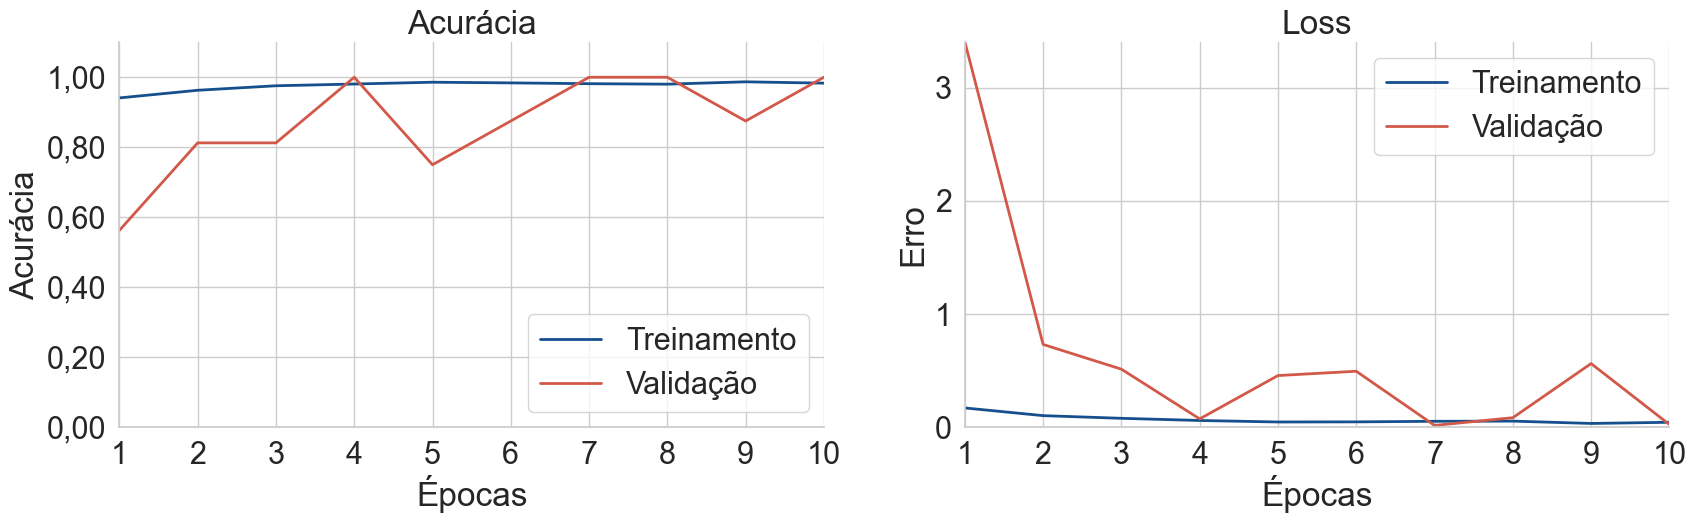

In [101]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params, 
              palette=color_pallete[0], font_scale=2)
#sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(1,2, figsize = (20,5))

# incep
sns.lineplot(acc_incp, label='Treinamento',ax = ax[0], linewidth = 2)
sns.lineplot(val_acc_incep, label='Validação',ax = ax[0], linewidth = 2)
ax[0].set_ylim([0,1.10])
ax[0].set_xlim([0,9])
ax[0].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[0].legend(loc='lower right') 
ax[0].set_title("Acurácia")
ax[0].set_xlabel("Épocas")
ax[0].set_ylabel("Acurácia")
ax[0].yaxis.set_major_formatter(FuncFormatter(format_decimais))


# incep
sns.lineplot(loss_incp, label='Treinamento',ax = ax[1], linewidth = 2)
sns.lineplot(loss_val_incp, label='Validação',ax = ax[1], linewidth = 2)

ax[1].set_ylim([0,3.4])
ax[1].set_xlim([0,9])
ax[1].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[1].legend(loc='upper right') 
ax[1].set_title("Loss")
ax[1].set_xlabel("Épocas")
ax[1].set_ylabel("Erro")
# ax[1].yaxis.set_major_formatter(FuncFormatter(format_with_commas_locale))

plt.show()

> Curva de aprendizado para o modelo VGG-16

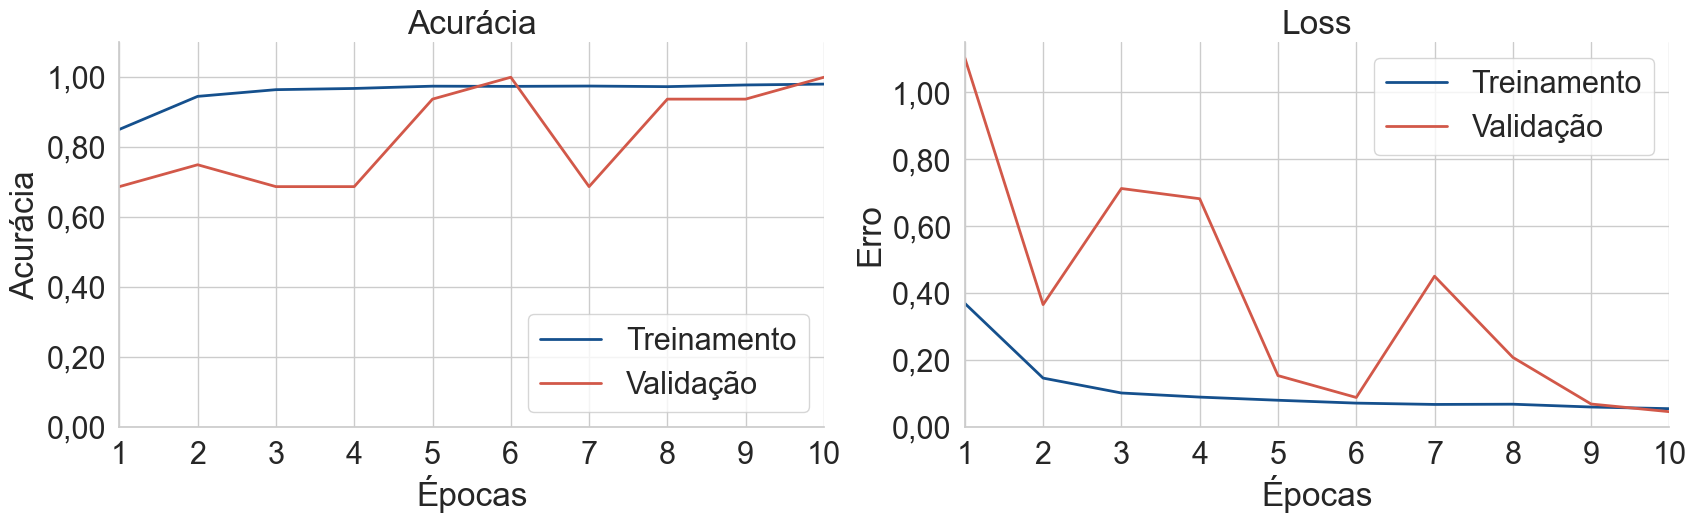

In [102]:
fig, ax = plt.subplots(1,2, figsize = (20,5))

# vgg
sns.lineplot(acc_vgg, label='Treinamento',ax = ax[0], linewidth = 2)
sns.lineplot(val_acc_vgg, label='Validação',ax = ax[0], linewidth = 2)
ax[0].set_ylim([0,1.10])
ax[0].set_xlim([0,9])
ax[0].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[0].legend(loc='lower right') 
ax[0].set_title("Acurácia")
ax[0].set_xlabel("Épocas")
ax[0].set_ylabel("Acurácia")
ax[0].yaxis.set_major_formatter(FuncFormatter(format_decimais))

# vgg
sns.lineplot(loss_vgg, label='Treinamento',ax = ax[1], linewidth = 2)
sns.lineplot(loss_val_vgg, label='Validação',ax = ax[1], linewidth = 2)

ax[1].set_ylim([0,1.15])
ax[1].set_xlim([0,9])
ax[1].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[1].legend(loc='upper right') 
ax[1].set_title("Loss")
ax[1].set_xlabel("Épocas")
ax[1].set_ylabel("Erro")
ax[1].yaxis.set_major_formatter(FuncFormatter(format_decimais))

> Comparação da curva de aprendizagem entre ambos os modelos

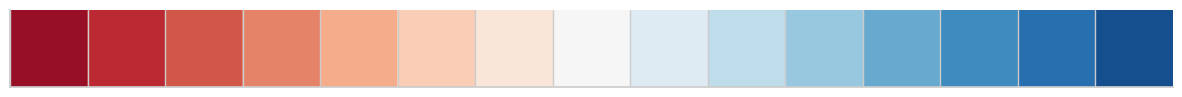

In [104]:
colors = sns.color_palette("RdBu", 15)
sns.palplot(colors)

color_pallete = []
color_pallete.append([colors[14],colors[2]])

Text(0, 0.5, 'Erro')

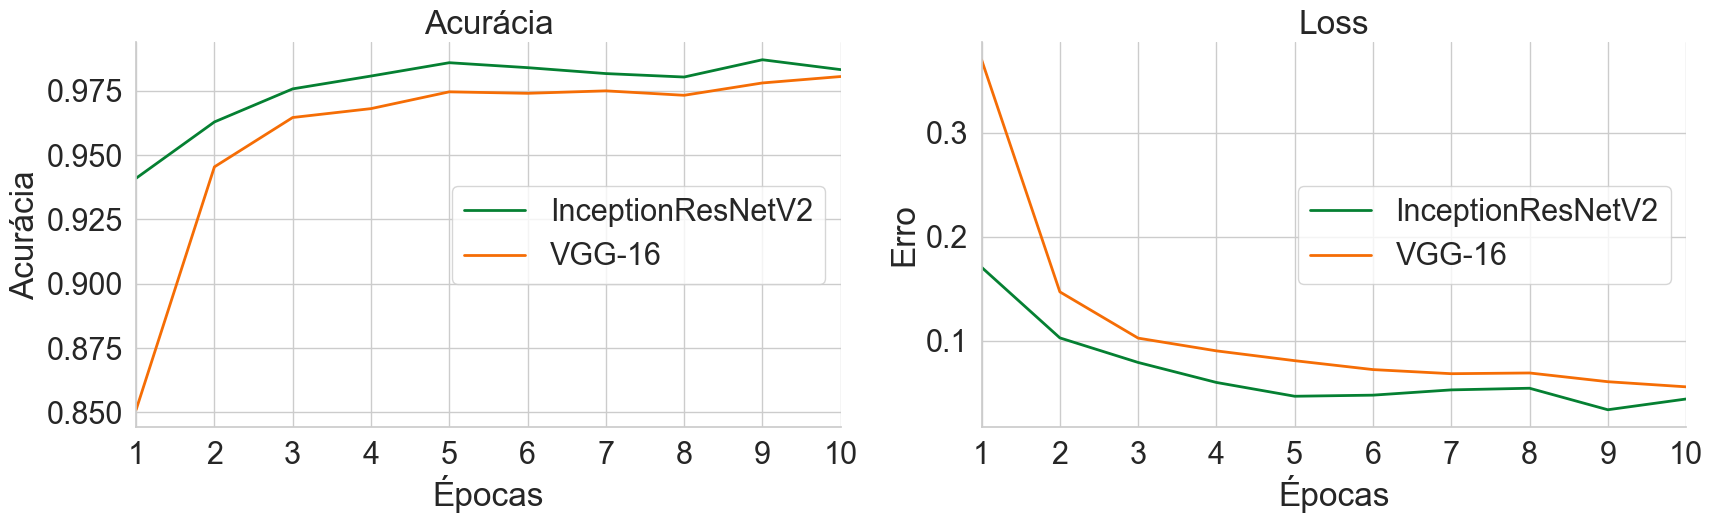

In [105]:
sns.set_theme(style="whitegrid", rc=custom_params, 
              palette=["#058032","#f56d05"], font_scale=2)

fig, ax = plt.subplots(1,2, figsize = (20,5))

# incep
sns.lineplot(acc_incp, label='InceptionResNetV2',ax = ax[0], linewidth = 2)
sns.lineplot(acc_vgg, label='VGG-16',ax = ax[0], linewidth = 2)
# ax[0].set_ylim([0,1])
ax[0].set_xlim([0,9])
ax[0].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[0].legend(loc='center right') 
ax[0].set_title("Acurácia")
ax[0].set_xlabel("Épocas")
ax[0].set_ylabel("Acurácia")

# vgg
sns.lineplot(loss_incp, label='InceptionResNetV2',ax = ax[1], linewidth = 2)
sns.lineplot(loss_vgg, label='VGG-16',ax = ax[1], linewidth = 2)

# ax[1].set_ylim([0,1])
ax[1].set_xlim([0,9])
ax[1].set_xticks(np.arange(0,10),np.arange(1,11)) 
ax[1].legend(loc='center right') 
ax[1].set_title("Loss")
ax[1].set_xlabel("Épocas")
ax[1].set_ylabel("Erro")

### Classificação

In [106]:
prev_incep_1 = RN_inception_loaded_FT.predict(ds_test_Incep)
prev_incep = np.argmax(prev_incep_1, axis = 1)

prev_vgg_1 = RN_vgg_loaded_FT.predict(ds_test_vgg)
prev_vgg = np.argmax(prev_vgg_1, axis = 1)

624/624 [==============================] - 8s 12ms/step


In [107]:
color_pallete2 = []
color_pallete2.append([colors[6],colors[14],colors[2]])
color_pallete2[0]

[(0.9829296424452134, 0.9018838908112264, 0.8542099192618224),
 (0.08419838523644753, 0.31280276816609, 0.5534025374855824),
 (0.8226066897347174, 0.34325259515570933, 0.28627450980392155)]

> Matriz de confusão

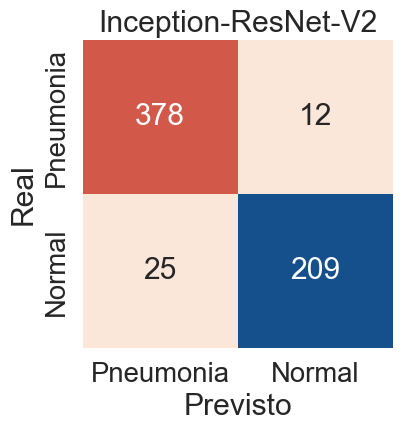

In [108]:
label = ['Pneumonia', "Normal"]
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.8)
fig, ax = plt.subplots(figsize = (4,4))

cm_1 = confusion_matrix(ds_test_Incep.classes, prev_incep,labels=[1,0])
sns.heatmap(cm_1, annot=True,fmt='d', 
            xticklabels=label, yticklabels=label,cmap=color_pallete2[0], cbar=False)
ax.set_title("Inception-ResNet-V2")
ax.set_xlabel("Previsto")
ax.set_ylabel("Real")
plt.show()

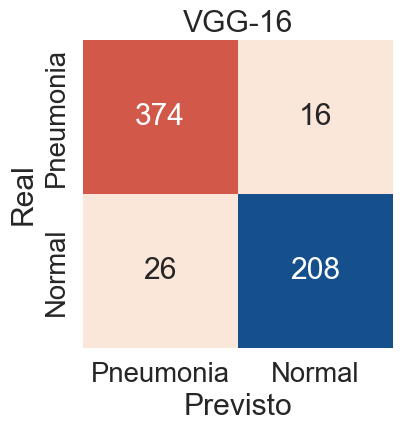

In [109]:
label = ['Pneumonia', "Normal"]
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.8)
fig, ax = plt.subplots(figsize = (4,4))

cm_2 = confusion_matrix(ds_test_vgg.classes, prev_vgg,labels=[1,0])
sns.heatmap(cm_2, annot=True,fmt='d', xticklabels=label, 
            yticklabels=label,cmap=color_pallete2[0], cbar=False)
ax.set_title("VGG-16")
ax.set_xlabel("Previsto")
ax.set_ylabel("Real")

plt.show()

> Visualização das métricas de avaliação pelo Classification Report

In [111]:
print('-------------------------------------------------------')
print('>>>>>>>>>>>>>>> Classification Report <<<<<<<<<<<<<<<<<')
print('-------------------------------------------------------')
print('----------------> InceptionResNetV2 <------------------')
print(classification_report(ds_test_Incep.classes, prev_incep,
                            target_names=label,labels=[1,0]))
print('-------------------------------------------------------')
print('----------------------> VGG16 <------------------------')
print(classification_report(ds_test_vgg.classes, prev_vgg,
                            target_names=label,labels=[1,0]))
print('-------------------------------------------------------')

-------------------------------------------------------
>>>>>>>>>>>>>>> Classification Report <<<<<<<<<<<<<<<<<
-------------------------------------------------------
----------------> InceptionResNetV2 <------------------
              precision    recall  f1-score   support

   Pneumonia       0.94      0.97      0.95       390
      Normal       0.95      0.89      0.92       234

    accuracy                           0.94       624
   macro avg       0.94      0.93      0.94       624
weighted avg       0.94      0.94      0.94       624

-------------------------------------------------------
----------------------> VGG16 <------------------------
              precision    recall  f1-score   support

   Pneumonia       0.94      0.96      0.95       390
      Normal       0.93      0.89      0.91       234

    accuracy                           0.93       624
   macro avg       0.93      0.92      0.93       624
weighted avg       0.93      0.93      0.93       624

----------

### Curva ROC e a Curva Precision-Recall

In [112]:
fpr_inc, tpr_inc, _ = roc_curve(ds_test_Incep.classes, prev_incep)
fpr_vgg, tpr_vgg, _ = roc_curve(ds_test_vgg.classes, prev_vgg)

roc_auc_inc = auc(fpr_inc, tpr_inc)
roc_auc_vgg = auc(fpr_vgg, tpr_vgg)

C:\Users\giull\AppData\Local\Temp\ipykernel_16368\3614032500.py:23: DeprecationWarning: This method will be removed in a future version of Python. Use 'locale.format_string()' instead.
  ax[0].plot(fpr_inc, tpr_inc, lw=2, label='IncepRes (AUC = %s)' % locale.format("%.2f",roc_auc_inc))
C:\Users\giull\AppData\Local\Temp\ipykernel_16368\3614032500.py:24: DeprecationWarning: This method will be removed in a future version of Python. Use 'locale.format_string()' instead.
  ax[0].plot(fpr_vgg, tpr_vgg, lw=2, label='VGG16 (AUC = %s)' % locale.format("%.2f",roc_auc_vgg))
C:\Users\giull\AppData\Local\Temp\ipykernel_16368\3614032500.py:36: DeprecationWarning: This method will be removed in a future version of Python. Use 'locale.format_string()' instead.
  ax[1].plot(recall, precision, label = 'IncepRes (AP = (%s)' % locale.format("%.2f",ap_incep), lw =2)
C:\Users\giull\AppData\Local\Temp\ipykernel_16368\3614032500.py:37: DeprecationWarning: This method will be removed in a future version of Py

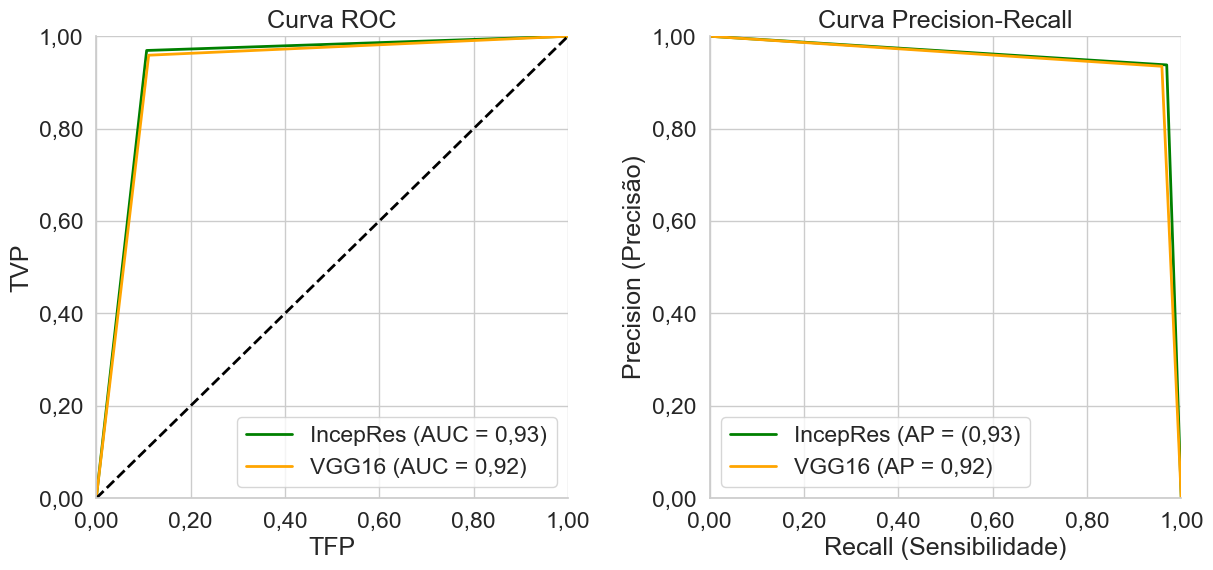

In [115]:
precision, recall, thresholds = precision_recall_curve(ds_test_Incep.classes, prev_incep)
precision2, recall2, thresholds2 = precision_recall_curve(ds_test_vgg.classes, prev_vgg)

precision[0] = 0
precision2[0] = 0

ap_incep = average_precision_score(ds_test_Incep.classes, prev_incep)
ap_vgg = average_precision_score(ds_test_vgg.classes, prev_vgg)

# auc_incep_truncado = math.trunc(roc_auc_inc * 100) / 100.0
# auc_vgg_truncado = math.trunc(roc_auc_vgg * 100) / 100.0

# ap_incep_truncado = math.trunc(ap_incep * 100) / 100.0
# ap_vgg_truncado = math.trunc(ap_vgg * 100) / 100.0


sns.set_theme(style="whitegrid", rc=custom_params, 
              palette=["Green","Orange"], font_scale=1.5)

fig, ax = plt.subplots(1,2, figsize = (14,6))
plt.subplots_adjust(wspace=0.3)

ax[0].plot(fpr_inc, tpr_inc, lw=2, label='IncepRes (AUC = %s)' % locale.format("%.2f",roc_auc_inc))
ax[0].plot(fpr_vgg, tpr_vgg, lw=2, label='VGG16 (AUC = %s)' % locale.format("%.2f",roc_auc_vgg))
ax[0].plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
ax[0].set_xlabel('TFP')
ax[0].set_ylabel('TVP')
ax[0].set_title('Curva ROC')
ax[0].legend(loc="lower right")
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1])
ax[0].yaxis.set_major_formatter(FuncFormatter(format_decimais))
ax[0].xaxis.set_major_formatter(FuncFormatter(format_decimais))

# Plota a curva de precisão e recall
ax[1].plot(recall, precision, label = 'IncepRes (AP = (%s)' % locale.format("%.2f",ap_incep), lw =2)
ax[1].plot(recall2, precision2,label = 'VGG16 (AP = %s)' % locale.format("%.2f",ap_vgg), lw =2)
ax[1].set_xlabel('Recall (Sensibilidade)')
ax[1].set_ylabel('Precision (Precisão)')
ax[1].set_title('Curva Precision-Recall')
# ax[1].grid(True)
ax[1].legend(loc="lower left")
ax[1].set_xlim([0,1])
ax[1].set_ylim([0,1])
ax[1].yaxis.set_major_formatter(FuncFormatter(format_decimais))
ax[1].xaxis.set_major_formatter(FuncFormatter(format_decimais))

plt.show()